In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
label_dir='/content/drive/MyDrive/segmentation/segmentation/segmentaion_labels/train'
image_dir='/content/drive/MyDrive/segmentation/segmentation/segmentation_images/train'

In [ ]:
import numpy as np
Sky = [128,128,128]
Building = [128,0,0]
Pole = [192,192,128]
Road = [128,64,128]
Pavement = [60,40,222]
Tree = [128,128,0]
SignSymbol = [192,128,128]
Fence = [64,64,128]
Car = [64,0,128]
Pedestrian = [64,64,0]
Bicyclist = [0,128,192]
Unlabelled = [0,0,0]

COLOR_DICT = np.array([Sky, Building, Pole, Road, Pavement,
                          Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])


In [ ]:
# Create the augmented_data directory if it doesn't exist
# augmented_data_dir = os.path.join(os.path.dirname(image_dir), "augmented_data")
# os.makedirs(augmented_data_dir, exist_ok=True)

In [ ]:

# # Create the generator
# myGenerator = trainGenerator(
#     batch_size=20,
#     image_dir=image_dir,
#     mask_dir=label_dir,
#     aug_dict=data_gen_args,
#     save_to_dir=os.path.join(os.path.dirname(image_dir), "augmented_data")
# )

# # Generate augmented data

# num_batch = 3
# for i, batch in enumerate(myGenerator):
#     if i >= num_batch:
#         break

# print(f"Generated {num_batch * 20} augmented images and masks in {os.path.join(os.path.dirname(image_dir), 'augmented_data')}")

Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
Generated 60 augmented images and masks in /content/drive/MyDrive/segmentation/segmentation/segmentation_images/augmented_data


In [ ]:
def labelVisualize(num_class,color_dict,img):
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i,:] = color_dict[i]
    return img_out / 255



def saveResult(save_path,npyfile,flag_multi_class = False,num_class = 2):
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
        io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(input)
    x = Conv2D(num_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
    return x

def unetplusplus(input_size=(256, 256, 1), n_filters=64, dropout=0.1, batchnorm=True):
    inputs = Input(input_size)

    c1 = conv_block(inputs, n_filters)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv_block(p1, n_filters*2)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    up1_2 = UpSampling2D((2, 2))(c2)
    up1_2 = concatenate([up1_2, c1])
    c1_2 = conv_block(up1_2, n_filters)

    c3 = conv_block(p2, n_filters*4)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    up2_2 = UpSampling2D((2, 2))(c3)
    up2_2 = concatenate([up2_2, c2])
    c2_2 = conv_block(up2_2, n_filters*2)

    up1_3 = UpSampling2D((2, 2))(c2_2)
    up1_3 = concatenate([up1_3, c1, c1_2])
    c1_3 = conv_block(up1_3, n_filters)

    c4 = conv_block(p3, n_filters*8)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    up3_2 = UpSampling2D((2, 2))(c4)
    up3_2 = concatenate([up3_2, c3])
    c3_2 = conv_block(up3_2, n_filters*4)

    up2_3 = UpSampling2D((2, 2))(c3_2)
    up2_3 = concatenate([up2_3, c2, c2_2])
    c2_3 = conv_block(up2_3, n_filters*2)

    up1_4 = UpSampling2D((2, 2))(c2_3)
    up1_4 = concatenate([up1_4, c1, c1_2, c1_3])
    c1_4 = conv_block(up1_4, n_filters)

    c5 = conv_block(p4, n_filters*16)

    up4_2 = UpSampling2D((2, 2))(c5)
    up4_2 = concatenate([up4_2, c4])
    c4_2 = conv_block(up4_2, n_filters*8)

    up3_3 = UpSampling2D((2, 2))(c4_2)
    up3_3 = concatenate([up3_3, c3, c3_2])
    c3_3 = conv_block(up3_3, n_filters*4)

    up2_4 = UpSampling2D((2, 2))(c3_3)
    up2_4 = concatenate([up2_4, c2, c2_2, c2_3])
    c2_4 = conv_block(up2_4, n_filters*2)

    up1_5 = UpSampling2D((2, 2))(c2_4)
    up1_5 = concatenate([up1_5, c1, c1_2, c1_3, c1_4])
    c1_5 = conv_block(up1_5, n_filters)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c1_5)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Usage
model = unetplusplus(input_size=(256, 256, 1))
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 256, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_62 (Conv2D)        │ (None, 256, 256, 64)   │            640 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_63 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ conv2d_62[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 128, 128, 64)   │              0 │ conv2d_63[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 128, 128, 64)   │              0 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_64 (Conv2D)        │ (None, 128, 128, 128)  │         73,856 │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_65 (Conv2D)        │ (None, 128, 128, 128)  │        147,584 │ conv2d_64[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 64, 64, 128)    │              0 │ conv2d_65[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 64, 64, 128)    │              0 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_68 (Conv2D)        │ (None, 64, 64, 256)    │        295,168 │ dropout_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_69 (Conv2D)        │ (None, 64, 64, 256)    │        590,080 │ conv2d_68[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 32, 32, 256)    │              0 │ conv2d_69[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 32, 32, 256)    │              0 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_74 (Conv2D)        │ (None, 32, 32, 512)    │      1,180,160 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_75 (Conv2D)        │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_74[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_11          │ (None, 16, 16, 512)    │              0 │ conv2d_75[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 16, 16, 512)    │              0 │ max_pooling2d_11[0][0] │
├──────────────────────

 Total params: 36,613,889 (139.67 MB)

 Trainable params: 36,613,889 (139.67 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

label_dir = '/content/drive/MyDrive/segmentation/segmentation/segmentaion_labels/train'
image_dir = '/content/drive/MyDrive/segmentation/segmentation/segmentation_images/train'

# Create data generator
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')

myGene = trainGenerator(2, image_dir, label_dir, data_gen_args, save_to_dir=None)

model = unetplusplus()
model_checkpoint = ModelCheckpoint('unet_membrane.keras', monitor='loss', verbose=1, save_best_only=True)

history=model.fit(myGene, steps_per_epoch=1000, epochs=5, callbacks=[model_checkpoint])



Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
Epoch 1/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.8684 - loss: 1.2461
Epoch 1: loss improved from inf to 0.93432, saving model to unet_membrane.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 339s 321ms/step - accuracy: 0.8685 - loss: 1.2458
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9181 - loss: 0.5567
Epoch 2: loss improved from 0.93432 to 0.51050, saving model to unet_membrane.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 328s 328ms/step - accuracy: 0.9181 - loss: 0.5566
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9298 - loss: 0.4080
Epoch 3: loss improved from 0.51050 to 0.38560, saving model to unet_membrane.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 328s 328ms/step - accuracy: 0.9298 - loss: 0.4080
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.9374 - loss: 0.3296
Epoch 4: loss improved from 0.38560 to 0.31516, saving model to unet_memb

In [ ]:
# Save the model
model.save('/content/drive/MyDrive/unet_membrane_latest.keras')

In [ ]:

from tensorflow.keras.models import load_model

loaded_model = load_model('/content/drive/MyDrive/unet_membrane_latest.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 126 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


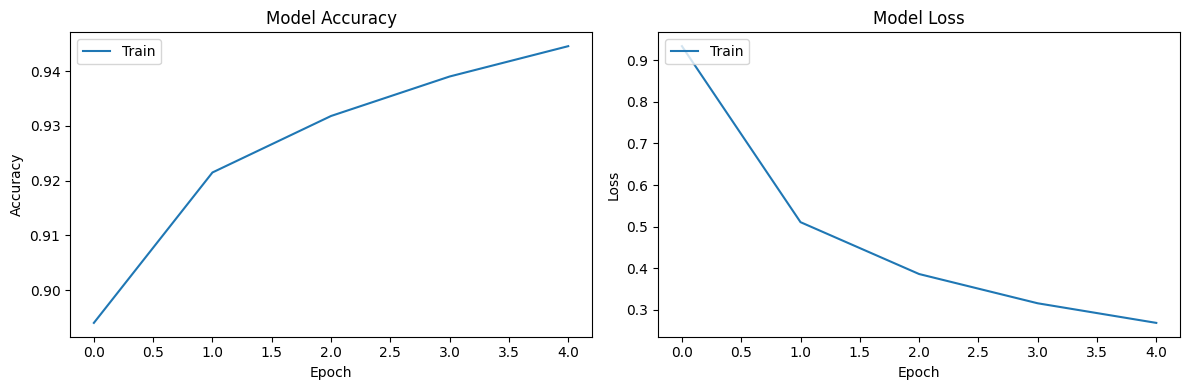

In [ ]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


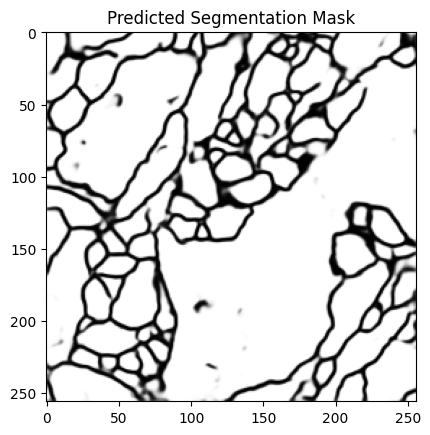

Prediction completed. Shape of results: (1, 256, 256, 1)


In [ ]:
test_dir = '/content/drive/MyDrive/segmentation/segmentation/segmentedtest'
testGene = testGenerator(test_dir, num_image=1)

# Predict the segmentation mask for the test image
results = model.predict(testGene, steps=1, verbose=1)

# Display the predicted segmentation mask
predicted_image = results[0].squeeze()

# Plot the predicted mask
plt.imshow(predicted_image, cmap='gray')
plt.title('Predicted Segmentation Mask')
plt.show()

print("Prediction completed. Shape of results:", results.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


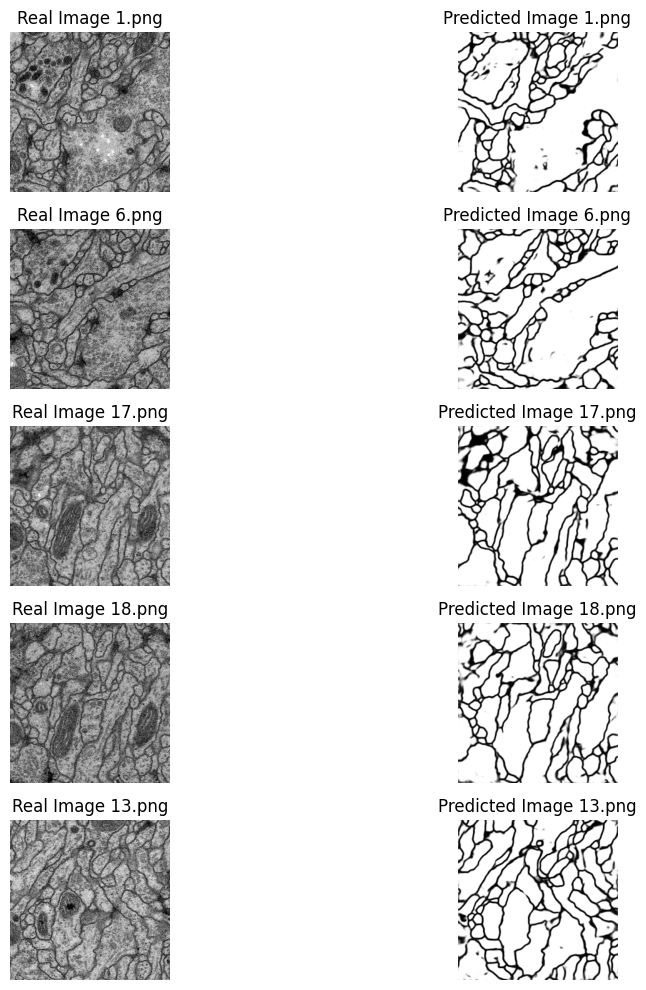

In [ ]:
from skimage import io, transform
import random

def testGenerator1(test_path, image_list, target_size=(256, 256), flag_multi_class=False, as_gray=True):
    for img_name in image_list:
        img_path = os.path.join(test_path, img_name)
        img = io.imread(img_path, as_gray=as_gray)
        img = img / 255.0
        img = transform.resize(img, target_size)
        if not flag_multi_class:
            img = np.reshape(img, img.shape + (1,))
        img = np.reshape(img, (1,) + img.shape)
        yield img


# Test images directory
test_path = '/content/drive/MyDrive/segmentation/segmentation/segmentedtest'

# Get a list of test images
all_images = [f for f in os.listdir(test_path) if f.endswith('.png')]
random_images = random.sample(all_images, 5)  # Randomly select 5 images

# Initialize lists to hold real images and predictions
real_images = []
predicted_images = []

# Generate test images and make predictions
test_gen = testGenerator1(test_path, random_images)
for img_name in random_images:
    img = next(test_gen)  # Get the image from the generator
    prediction = model.predict(img)
    predicted_images.append(prediction[0].squeeze())

    # Load the corresponding real image for comparison
    real_image = io.imread(os.path.join(test_path, img_name), as_gray=True) / 255.0  # Load and normalize the real image
    real_images.append(real_image)

# Plot real and predicted images
plt.figure(figsize=(12, 10))

for i in range(len(random_images)):
    # Display real image
    plt.subplot(len(random_images), 2, i * 2 + 1)
    plt.imshow(real_images[i], cmap='gray')
    plt.title(f'Real Image {random_images[i]}')
    plt.axis('off')

    # Display predicted segmentation mask
    plt.subplot(len(random_images), 2, i * 2 + 2)
    plt.imshow(predicted_images[i], cmap='gray')
    plt.title(f'Predicted Image {random_images[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()
